# 4章 ニューラルネットワークの学習

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt

## 4.2 損失関数

### 4.2.3　ミニバッチ学習

In [2]:
random_choice = np.random.choice(10, size=10, replace=False)
print(random_choice)

[5 3 9 4 8 2 7 0 1 6]


### 4.2.4 交差エントロピー誤差の実装

出力の形: (バッチ数)$\times$(出力数)

In [3]:
def cross_entropy_error(y, t):
    # 出力が1次元、すなわちバッチ処理ではない場合にはバッチ処理と同じ次元にする
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    # 正解ラベルがインデックスの場合の計算
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

バッチ処理でない(出力が1次元)場合の次元の変換

In [4]:
y1 = np.array([1,2,3,4])
y2 = y1.reshape(1, y1.size)
print(f'y2 = {y2}')
print(f'shape = {y2.shape}')

y2 = [[1 2 3 4]]
shape = (1, 4)


one-hot表現から正解ラベルのインデックスへの変換

In [5]:
y1 = y1 = np.array([1,2,4,3])
y3 = y1.reshape(2,2)
print(f'y3 = {y3}')
ind = y3.argmax(axis=1)
print(f'index = {ind}')

y3 = [[1 2]
 [4 3]]
index = [1 0]


正解ラベルのインデックスの値を取り出す方法

In [6]:
y4 = np.array([[1, 2],[3, 4],[5,6]])
print(y4)
y4[[0,1,2], [1,0,1]]

[[1 2]
 [3 4]
 [5 6]]


array([2, 3, 6])

## 4.4 勾配

関数の定義 $x_1^2 + x_2^2 + \cdots + x_n^2$  1行の入力ベクトルは`[x1, x2, ... , xn]`

In [7]:
def function_2(x):
    if x.ndim == 1:  # 単独のベクトルの場合
        return np.sum(x**2)
    else:            # バッチ処理の場合
        return np.sum(x**2, axis=1)

各点の勾配を求める
$$
\frac{\partial f}{\partial x_i} = \frac{f(x_1, x_2, \cdots , x_i+h, \cdots, x_n)-f(x_1, x_2, \cdots , x_i-h, \cdots, x_n)}{2h}
$$

$$
\mathrm{grad} f = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \cdots, \frac{\partial f}{\partial x_i}, \cdots, \frac{\partial f}{\partial x_n} \right)
$$

In [8]:
def _numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    # xは1次元ベクトル
    grad = np.zeros_like(x)
    
    # 各変数に対して偏微分係数を計算
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad

複数の点の勾配を求める

In [9]:
def numerical_gradient(f, X):
    # バッチ処理であれば X.ndim == 2
    if X.ndim == 1:
        return _numerical_gradient(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient(f, x)
        
        return grad

numerical_gradient の確認


In [10]:
numerical_gradient(function_2, np.array([[3.0, 4.0], [0.0, 2.0], [3.0, 0.0]]))

array([[6., 8.],
       [0., 4.],
       [6., 0.]])

plot のデータ準備

In [11]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

X = X.flatten()
Y = Y.flatten()

print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

X.shape = (18, 18)
Y.shape = (18, 18)
X.shape = (324,)
Y.shape = (324,)


In [12]:
print(np.array([X, Y]).shape)
print(np.array([X, Y]).T.shape)

(2, 324)
(324, 2)


図のプロット

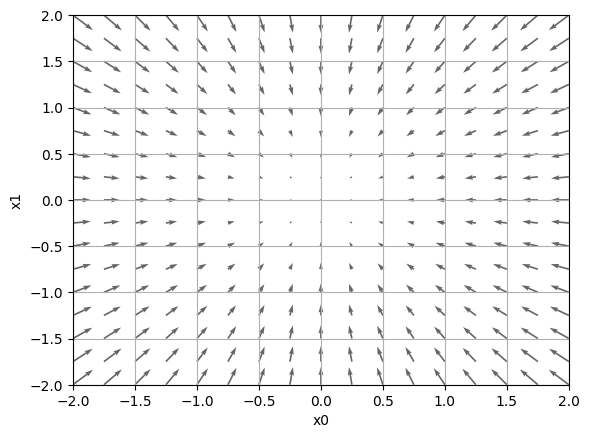

In [13]:
grad = numerical_gradient(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

### 4.4.1 勾配法

$$
x_0 = x_0 - \eta \frac{\partial f}{\partial x_0}
$$

$$
x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}
$$

勾配降下法

In [14]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

勾配降下法の例

[-7.63888491e-10  1.01851799e-09]


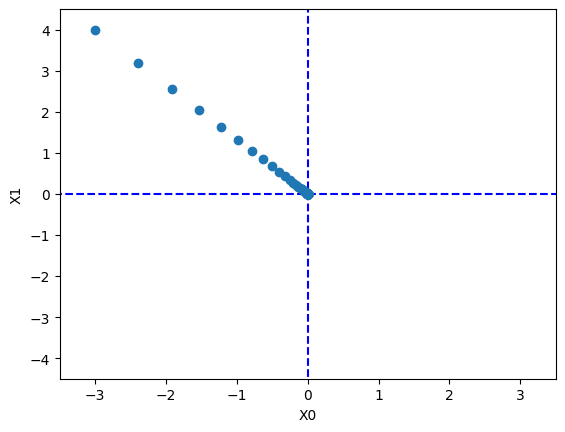

In [15]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 100
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

print(x_history[-1])

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### ニューラルネットワークに対する勾配

$$
W = \begin{pmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \end{pmatrix}
$$

$$
\frac{\partial L}{\partial W} = \begin{pmatrix} \displaystyle \frac{\partial L}{\partial w_{11} } & \displaystyle \frac{\partial L}{\partial w_{12} } & \displaystyle \frac{\partial L}{\partial w_{13} } \\[4mm] \displaystyle \frac{\partial L}{\partial w_{21} } & \displaystyle \frac{\partial L}{\partial w_{22} } & \displaystyle \frac{\partial L}{\partial w_{23} } \end{pmatrix}
$$


多次元配列に対する数値微分 (パラメータ)

In [16]:
def numerical_gradient(f, x):
    h = 1e-4   # 0.0001 微小な変化量（刻み幅）を設定
    grad = np.zeros_like(x)    # xと同じ形状のゼロベクトルを作成し、勾配を初期化
    
    # xを多次元配列として反復処理するためのイテレータを作成
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index   # インデックスを取得
        tmp_val = x[idx]       # xの現在の値を一時的に保存
        x[idx] = tmp_val + h   # xの要素をhだけ増やして、
        fxh1 = f(x)            # 関数fを評価（f(x+h)の計算）
        
        x[idx] = tmp_val - h   # xの要素をhだけ減らして、
        fxh2 = f(x)            # 関数fを評価（f(x-h)の計算）
        
        grad[idx] = (fxh1 - fxh2) / (2*h)  # 勾配の計算（数値微分の定義に従って）
        
        x[idx] = tmp_val       # xの要素を元に戻す
        it.iternext()          # イテレータを次に進める
        
    # 計算された勾配ベクトルを返す
    return grad

#### Numpy の nditer の使い方

下記のコードでは、`np.nditer`を使用して多次元配列を反復処理しています。`flags`オプションでは、反復処理中にインデックス情報を取得するために`'multi_index'`を指定し、`op_flags`オプションでは読み取りと書き込みの権限を指定します。

ループ内では、`it[0]`を使用して現在の要素にアクセスし、`it.multi_index`を使用して現在のインデックスを取得しています。その後、`it.iternext()`を呼び出してイテレータを次に進めます。

In [17]:
import numpy as np

# 2次元のNumPy配列を作成します。
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# np.nditerを使用して配列を反復処理します。
it = np.nditer(arr, flags=['multi_index'], op_flags=['readwrite'])

while not it.finished:
    # イテレータから現在の要素とそのインデックスを取得します。
    current_element = it[0]
    current_index = it.multi_index

    # ここで必要な処理を行います。
    print(f"Index: {current_index}, Value: {current_element}")

    # イテレータを次に進めます。
    it.iternext()

Index: (0, 0), Value: 1
Index: (0, 1), Value: 2
Index: (0, 2), Value: 3
Index: (1, 0), Value: 4
Index: (1, 1), Value: 5
Index: (1, 2), Value: 6
Index: (2, 0), Value: 7
Index: (2, 1), Value: 8
Index: (2, 2), Value: 9


パラメータによる勾配を求める例

In [18]:
from common.functions import softmax, cross_entropy_error

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [19]:
net = simpleNet()
print(net.W)

[[-0.67326074 -1.5642174   0.38133814]
 [-0.46614719  0.09636021  1.75648355]]


In [20]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.82348892 -0.85180625  1.80963808]


In [21]:
np.argmax(p)

2

In [22]:
t = np.array([0, 0, 1])
net.loss(x, t)

0.13251887129325665

In [23]:
f = lambda w: net.loss(x, t)

この場合、数値微分は `W` を変えた `net.loss(x, t)` を計算すれば良いが、`numerical_gradient(f, x)` は `f(x)` を計算するため、`f` はダミーの変数を必要とする。

In [24]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.03776125  0.03670695 -0.07446821]
 [ 0.05664188  0.05506043 -0.11170231]]


## 4.5 学習アルゴリズムの実装

### 4.5.1 2層ニューラルネットワーク

In [25]:
from dataset.mnist import load_mnist
from common.functions import *
from common.gradient import numerical_gradient

MNISTデータのラベルはone-hot表現

In [26]:
train_images, train_labels, test_images, test_labels = load_mnist(normalize=True, one_hot_label=True, flatten=True)

print("トレーニング画像の形状:", train_images.shape)
print("トレーニングラベルの形状:", train_labels.shape)
print("テスト画像の形状:", test_images.shape)
print("テストラベルの形状:", test_labels.shape)

トレーニング画像の形状: (60000, 784)
トレーニングラベルの形状: (60000, 10)
テスト画像の形状: (10000, 784)
テストラベルの形状: (10000, 10)


2層ニューラルネットワークの定義

In [27]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### 4.5.2 ミニバッチ学習の実装

In [28]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = train_images.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]
    
    # 勾配の計算
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# final result
train_acc = network.accuracy(train_images, train_labels)
test_acc = network.accuracy(test_images, test_labels)
print("final train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.7895166666666666, 0.7964
train acc, test acc | 0.8771, 0.8813
train acc, test acc | 0.89865, 0.901
train acc, test acc | 0.9093, 0.9104
train acc, test acc | 0.9147166666666666, 0.9161
train acc, test acc | 0.9202166666666667, 0.9218
train acc, test acc | 0.9239333333333334, 0.9255
train acc, test acc | 0.92715, 0.9294
train acc, test acc | 0.93075, 0.9307
train acc, test acc | 0.9337166666666666, 0.9326
train acc, test acc | 0.9360333333333334, 0.9359
train acc, test acc | 0.9393166666666667, 0.9377
train acc, test acc | 0.9411666666666667, 0.9389
train acc, test acc | 0.9434666666666667, 0.9404
train acc, test acc | 0.9451, 0.9427
train acc, test acc | 0.9460333333333333, 0.9439
final train acc, test acc | 0.9473, 0.9451


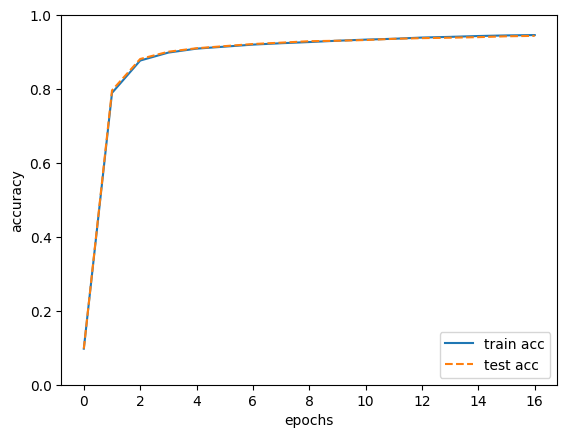

In [29]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()